# HW3: Regression

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.datasets as ds
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance
from scipy import stats

from pandas.core.frame import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor




### Preliminary: Updated Data Loading

In [37]:
df = pd.read_csv('data_HW3.csv', sep=',')


In [38]:
def prepare_data(training_data, new_data):
    copied_training_data = training_data.copy()
    copied_new_data = new_data.copy()

    delete = ["current_location", "pcr_date","patient_id"]
    standard_norm = ["happiness_score","num_of_siblings",'weight', "household_income", "sugar_levels", "PCR_06", "PCR_08",'PCR_10','age', "conversations_per_day"]
    min_max_norm = [ "PCR_07",'sport_activity', 'PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05' ,"PCR_09"]

    copied_new_data.household_income.fillna(copied_training_data.household_income.median(), inplace=True)

    # speical property
    copied_training_data['SpecialProperty'] = copied_training_data['blood_type'].isin(['O+', 'B+'])
    copied_training_data.drop(columns=['blood_type'], inplace=True)

    copied_new_data['SpecialProperty'] = copied_new_data['blood_type'].isin(['O+', 'B+'])
    copied_new_data.drop(columns=['blood_type'], inplace=True)

    # gender
    copied_training_data["sex"].replace({"F": 1, "M": -1}, inplace=True)
    copied_new_data["sex"].replace({"F": 1, "M": -1}, inplace=True)
    
    #delete columns
    copied_training_data.drop(columns=delete, inplace=True)
    copied_new_data.drop(columns=delete, inplace=True)

    # standard normalization
    scaler_standard = StandardScaler()
    scaler_standard.fit(copied_training_data[standard_norm])
    copied_new_data[standard_norm] = scaler_standard.transform(copied_new_data[standard_norm])

    # min max normalization
    scaler_minmax = MinMaxScaler(feature_range=(-1, 1))
    scaler_minmax.fit(copied_training_data[min_max_norm])
    copied_new_data[min_max_norm] = scaler_minmax.transform(copied_new_data[min_max_norm])
    

    return copied_new_data

In [39]:
# Split the data randomly into a training set (80% of the data) and a test set (20% of the data)
# our IDs: 206708463, 212201057
train_df, test_df = train_test_split(df, test_size=0.2, random_state=120) 
train_df_prepared = prepare_data(train_df, train_df) 
test_df_prepared = prepare_data(train_df, test_df)

In [40]:
# Pre-process the data to see which features can help us predict the target variable contamination_level

### Section 1: Linear regression implementation

In [41]:
############################## test gradients ##############################
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


In [42]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        # predict
        y_pred = np.dot(X, w) + b

        # mse loss
        loss = np.mean((y_pred - y) ** 2)

        return loss

    @staticmethod
    def gradient(w, b: float, X, y):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # Calculate the analytical gradient w.r.t w and b
        n_samples = X.shape[0]        
        y_pred = np.dot(X, w) + b
        g_w = np.multiply(2, 1 / n_samples) * np.dot(X.T, (y_pred - y))
        g_b = np.multiply(2, 1 / n_samples) * np.sum(y_pred - y)

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y)

            # Perform a gradient step
            # TODO: update the learned parameters correctly
            self.w = self.w - self.lr * g_w
            self.b = self.b - self.lr * g_b

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # Compute predictions
        y_pred = np.dot(X, self.w) + self.b

        return y_pred

In [43]:
# create validation set
train_df_prepared_temp, val_df_prepared = train_test_split(train_df_prepared, test_size=0.2, random_state=120)
X_train = train_df_prepared_temp.drop(columns=['contamination_level']).to_numpy()
y_train = train_df_prepared_temp['contamination_level'].to_numpy()
X_val = val_df_prepared.drop(columns=['contamination_level']).to_numpy()
y_val = val_df_prepared['contamination_level'].to_numpy()

X_test = test_df_prepared.drop(columns=['contamination_level']).to_numpy()
y_test = test_df_prepared['contamination_level'].to_numpy()

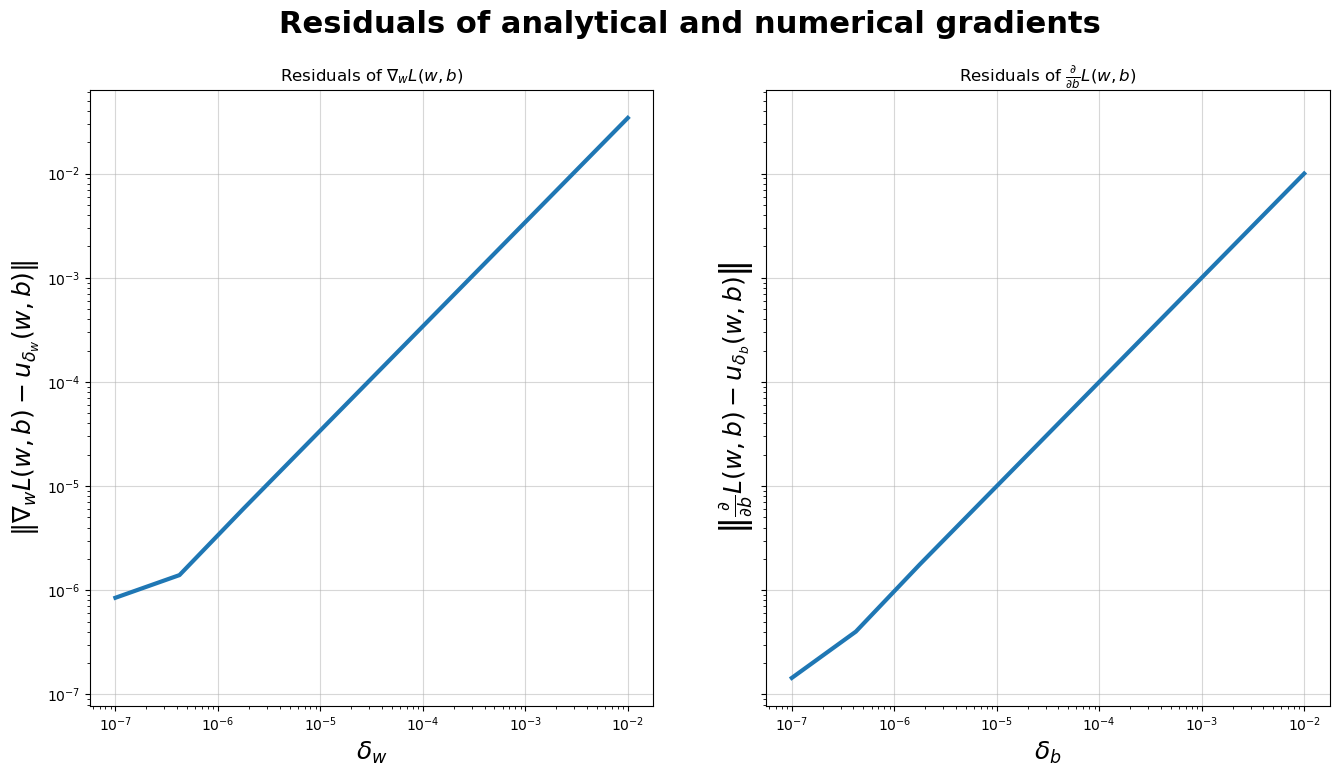

In [44]:
# compare gradients
compare_gradients(X_train, y_train, deltas=np.logspace(-7, -2, 9))

In [45]:
############################## test lr ##############################
import matplotlib.pyplot as plt
import numpy as np

def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)
  
  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

lr size = 1e-09, Best train loss = 0.07646399906867483, Best validation loss = 0.07444129429251536
lr size = 1e-08, Best train loss = 0.0764613941486118, Best validation loss = 0.07443912177241603
lr size = 1e-07, Best train loss = 0.07643535747155783, Best validation loss = 0.07441740668086003
lr size = 1e-06, Best train loss = 0.0761762381517278, Best validation loss = 0.07420126273665024
lr size = 1e-05, Best train loss = 0.0737050304365042, Best validation loss = 0.07213666795434498
lr size = 0.0001, Best train loss = 0.057400494818382074, Best validation loss = 0.05827336845093178
lr size = 0.001, Best train loss = 0.02446066121524469, Best validation loss = 0.026489764943082764
lr size = 0.01, Best train loss = 0.007355401015832454, Best validation loss = 0.007415807777586679
lr size = 0.1, Best train loss = 0.007358410564038912, Best validation loss = 0.007289249474553088


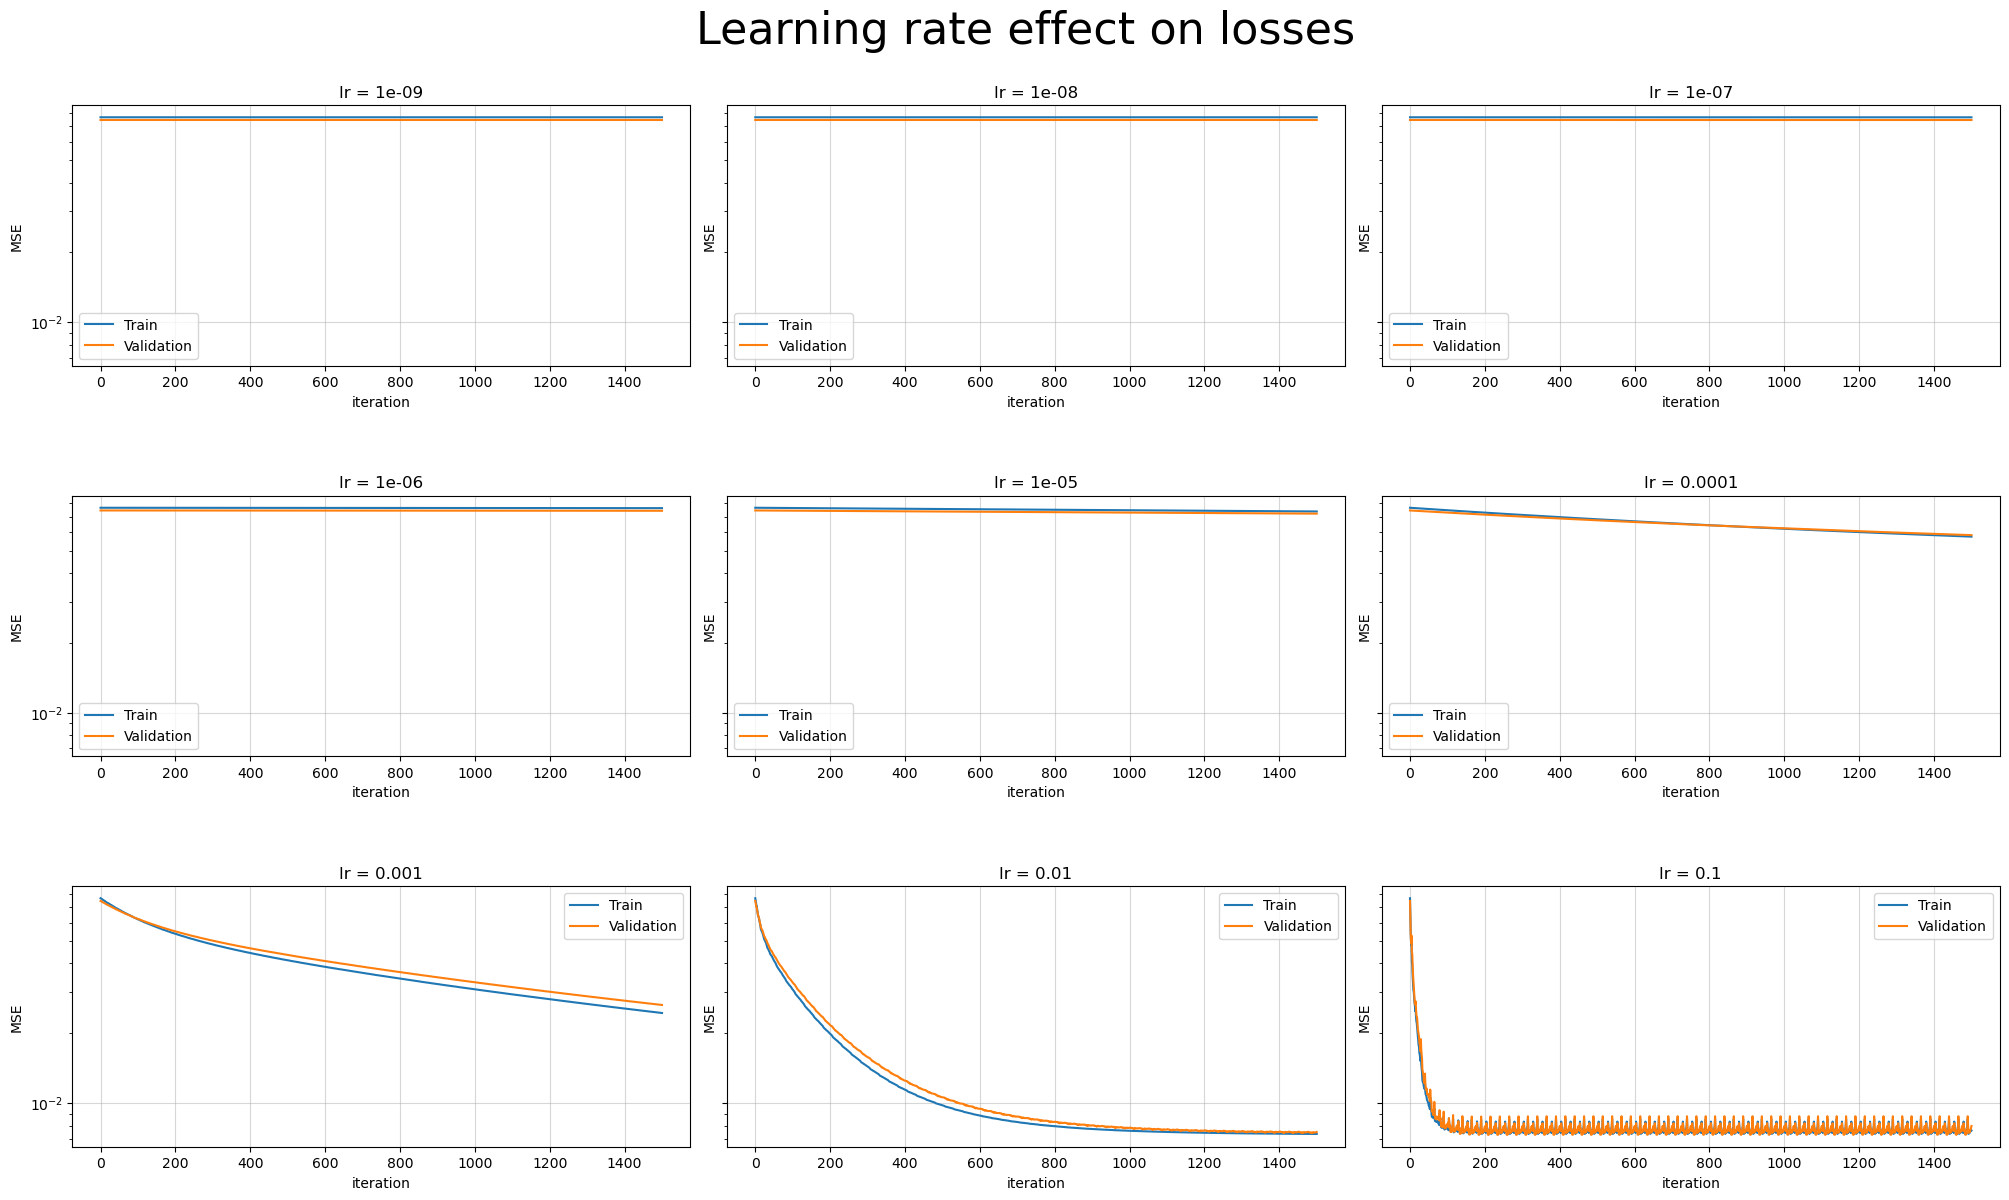

In [46]:
# Q3 We  now  want  to  evaluate  the  effects  of  different  learning  rates  on  the  learning 
# procedure. Run the following command that plots a graph of the training and validation 
# losses as a function of the iteration number for different learning rates
test_lr(X_train, y_train, X_val, y_val, 'Learning rate effect on losses')

In [47]:
# get back the train data
X_train = train_df_prepared.drop(columns=['contamination_level']).to_numpy()
y_train = train_df_prepared['contamination_level'].to_numpy()

In [48]:
from sklearn.model_selection import cross_validate

# Q4 Create a DummyRegressor. Evaluate its performance using cross-validation.
dummyRegressor = DummyRegressor(strategy="mean")

# Perform cross-validation
cv_scores = cross_validate(dummyRegressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Calculate the mean train error
train_error_dummy = -cv_scores['train_score'].mean()
val_error_dummy = -cv_scores['test_score'].mean()

# Print the mean train error and the cross-validated errors
print("Mean Train Error:", train_error_dummy)
print("Mean Cross-validated Error:", val_error_dummy)

Mean Train Error: 0.06565537988445821
Mean Cross-validated Error: 0.06582366402220992


In [49]:
# Task: Retrain the dummy regressor on the entire training set (= all its samples) and save it for 
# future use (Sec 6).
subset_dummy_X_train = X_train
subset_dummy_y_train = y_train
subset_dummy_X_test = X_test
subset_dummy_y_test = y_test

dummyRegressorForLater = DummyRegressor(strategy="mean")
dummyRegressorForLater.fit(subset_dummy_X_train, subset_dummy_y_train)

DummyRegressor()

### Basic hyperparameter tuning

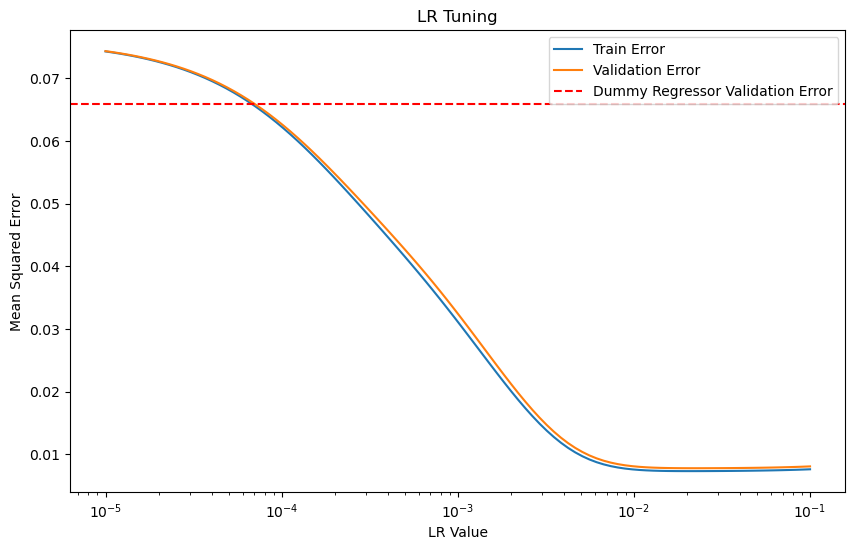

Optimal LR Value: 0.022570197196339216
Optimal Validation Error: 0.007755798673287341


In [50]:
import numpy as np

# The repeated tuning process (for a single parameter) should include: 
# i.  Determining the tested values of the tuned hyperparameter (see numpy.logspace). 
# You  need  to  choose  suitable  values  by  yourself  that  will  help  you  optimize  the 
# validation error. 
# ii.  For each value, evaluating a suitable regressor using cross validation (J = 5). 
# iii.  Plotting (cross-validated) train and validation errors as a function of the hyperparameter. 
# Consider using semilogx or loglog plots. 
# Also plot a constant line with the validation error of the dummy regressor. 
# iv.  Reporting the value that yields the optimal validation error and its respective error
import matplotlib.pyplot as plt

# i. Determine the tested values of the tuned hyperparameter
hyperparameter_values = np.logspace(-5, -1, 100)

# Initialize lists to store train and validation errors
train_errors = []
val_errors = []

# ii. For each value, evaluate a suitable regressor using cross validation
for value in hyperparameter_values:
    # Create and fit the regressor with the current hyperparameter value
    regressor = LinearRegressor(lr=value)
    cv_scores = cross_validate(regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    
    # Calculate the mean train and validation errors
    train_error = -cv_scores['train_score'].mean()
    val_error = -cv_scores['test_score'].mean()
    
    # Append the errors to the lists
    train_errors.append(train_error)
    val_errors.append(val_error)

# iii. Plot the train and validation errors as a function of the hyperparameter
plt.figure(figsize=(10, 6))
plt.semilogx(hyperparameter_values, train_errors, label='Train Error')
plt.semilogx(hyperparameter_values, val_errors, label='Validation Error')
plt.axhline(y=val_error_dummy, color='r', linestyle='--', label='Dummy Regressor Validation Error')
plt.xlabel('LR Value')
plt.ylabel('Mean Squared Error')
plt.title('LR Tuning')
plt.legend()
plt.show()

# iv. Report the value that yields the optimal validation error and its respective error
optimal_lr = hyperparameter_values[np.argmin(val_errors)]
optimal_error = np.min(val_errors)
print("Optimal LR Value:", optimal_lr)
print("Optimal Validation Error:", optimal_error)

In [51]:

# find the train score for the optimal lr
regressor = LinearRegressor(lr=optimal_lr)
cv_scores = cross_validate(regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    
# Calculate the mean train and validation errors
linear_train_error = -cv_scores['train_score'].mean()
linear_val_error = -cv_scores['test_score'].mean()

In [52]:
# Task: Using the best performing hyperparameter, retrain the regressor on the entire training 
# set (= with all its samples) and save it for future use
subset_linear_X_train = X_train
subset_linear_y_train = y_train
subset_linear_X_test = X_test
subset_linear_y_test = y_test

best_regressor = LinearRegressor(lr=optimal_lr)
best_regressor.fit(subset_linear_X_train, subset_linear_y_train)

LinearRegressor(lr=0.022570197196339216)

### Section 3: Lasso linear regression

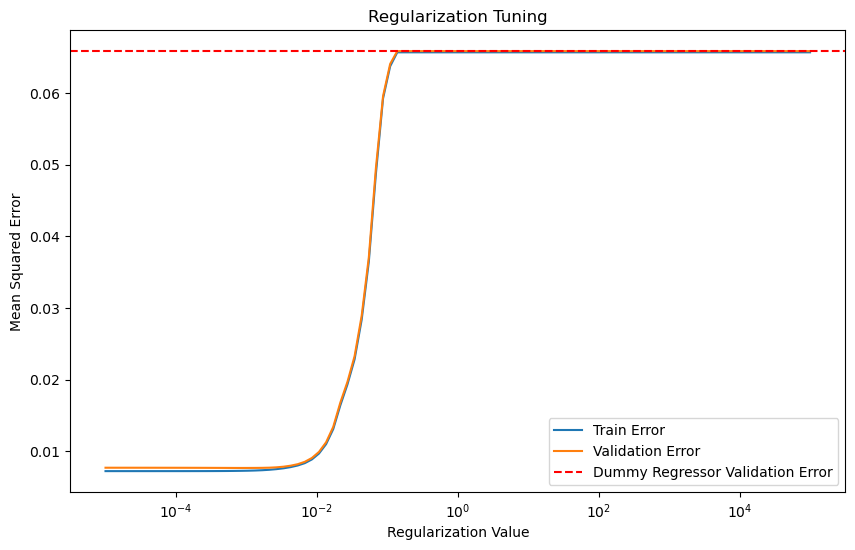

Optimal Regularization Value: 0.0008302175681319744
Optimal Validation Error: 0.007702296335533686


In [53]:
# Q7: Tune the regularization strength of the regressor. Follow the repeated tuning process 
# described earlier. Remember to attach the required plot and specify the optimal 
# strength with its validation error.  
# Remember that plot should have suitable titles, axis labels, grid lines, etc



hyperparameter_values = np.logspace(-5, 5, 100)

# Initialize lists to store train and validation errors
train_errors = []
val_errors = []

# ii. For each value, evaluate a suitable regressor using cross validation
for value in hyperparameter_values:
    # Create and fit the regressor with the current hyperparameter value
    regressor = Lasso(fit_intercept=True, alpha=value)
    cv_scores = cross_validate(regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    
    # Calculate the mean train and validation errors
    train_error = -cv_scores['train_score'].mean()
    val_error = -cv_scores['test_score'].mean()
    
    # Append the errors to the lists
    train_errors.append(train_error)
    val_errors.append(val_error)

# iii. Plot the train and validation errors as a function of the hyperparameter
plt.figure(figsize=(10, 6))
plt.semilogx(hyperparameter_values, train_errors, label='Train Error')
plt.semilogx(hyperparameter_values, val_errors, label='Validation Error')
plt.axhline(y=val_error_dummy, color='r', linestyle='--', label='Dummy Regressor Validation Error')
plt.xlabel('Regularization Value')
plt.ylabel('Mean Squared Error')
plt.title('Regularization Tuning')
plt.legend()
plt.show()

# iv. Report the value that yields the optimal validation error and its respective error
optimal_alpha = hyperparameter_values[np.argmin(val_errors)]
optimal_error = np.min(val_errors)
print("Optimal Regularization Value:", optimal_alpha)
print("Optimal Validation Error:", optimal_error)

In [54]:
# find the train score for the optimal alpha
regressor = Lasso(fit_intercept=True, alpha=optimal_alpha)
cv_scores = cross_validate(regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Calculate the mean train and validation errors
lasso_train_error = -cv_scores['train_score'].mean()
lasso_val_error = -cv_scores['test_score'].mean()

In [55]:
# Task: Using the best performing hyperparameter, retrain the regressor on the entire 
# training set (= with all its samples) and save it for future use
subset_lasso_X_train = X_train
subset_lasso_y_train = y_train
subset_lasso_X_test = X_test
subset_lasso_y_test = y_test


lassoRegressorForLater = Lasso(fit_intercept=True, alpha=optimal_alpha)
lassoRegressorForLater.fit(subset_lasso_X_train, subset_lasso_y_train)

Lasso(alpha=0.0008302175681319744)

In [56]:
# Q9: Specify the 5 features having the 5 largest coefficients (in absolute value) in the 
# resulting regressor, from the largest to the smallest (among these 5).
# Get the coefficients of the best regressor
coefficients = lassoRegressorForLater.coef_

# Get the absolute values of the coefficients
abs_coefficients = np.abs(coefficients)

# Get the indices of the 5 largest coefficients
largest_indices = np.argsort(abs_coefficients)[-5:]

# Get the feature names corresponding to the largest coefficients
feature_names = train_df_prepared.columns[0:-1]  # Exclude the 'patient_id' and 'contamination_level' columns


largest_features = feature_names[largest_indices - 1]

# Print the 5 features with the largest coefficients
print("Features with the 5 largest coefficients:")
for feature in largest_features:
    print(feature)

Features with the 5 largest coefficients:
PCR_08
PCR_05
conversations_per_day
PCR_01
PCR_03


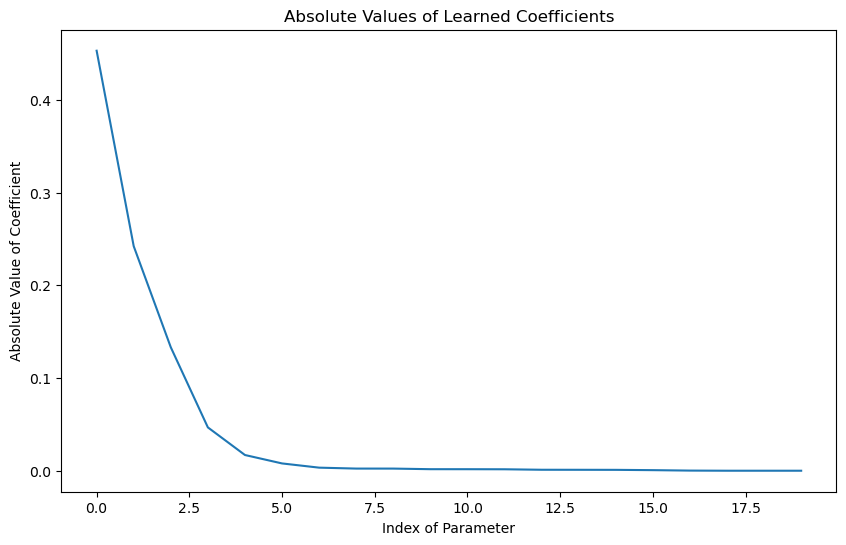

In [57]:
# Q10: Sort  and  plot  the  absolute  values  of  the  learned 
# coefficients.  The  x-axis  should  be  the  index  of  the 
# parameter from largest to smallest.  
# The result should roughly look like the illustration to the 
# right (in terms of axis and structure, the values her are 
# made up)
# Q10: Sort and plot the absolute values of the learned coefficients
sorted_indices = np.argsort(abs_coefficients)[::-1]
sorted_coefficients = abs_coefficients[sorted_indices]

plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_coefficients)), sorted_coefficients)
plt.xlabel('Index of Parameter')
plt.ylabel('Absolute Value of Coefficient')
plt.title('Absolute Values of Learned Coefficients')
plt.show()

In [58]:
# Task: Create a subset of the training set with these 2 features and contamination_level.
subset_train_df = train_df_prepared[['PCR_04', 'PCR_06', 'contamination_level']]
subset_X_train = subset_train_df.drop(columns=['contamination_level']).to_numpy()
subset_y_train = subset_train_df['contamination_level'].to_numpy()

In [59]:
###################### plot3d ######################
def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1, 
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    ax.view_init(elev=5., azim=45*i)
  
  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

C:\Users\t-abarham\AppData\Local\Temp\ipykernel_24084\171725059.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


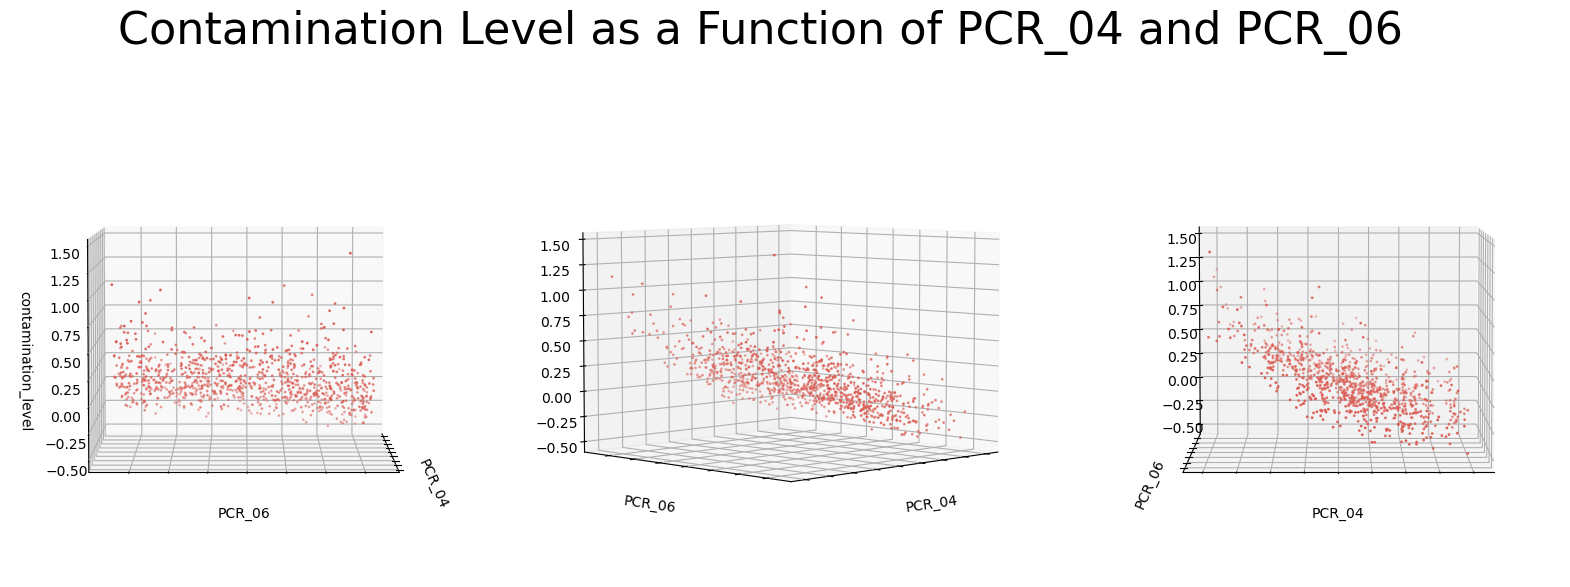

In [60]:
# Task: Visualize the data using plot3d, i.e., plot contamination_level as a function of 
# the PCR_04 and PCR_06 features.
plot3d(subset_train_df, 'PCR_04', 'PCR_06', 'contamination_level', 'Contamination Level as a Function of PCR_04 and PCR_06')

In [61]:
# Task:  Create  a  single  model  that:  (1)  transforms  the  original  features  into  4th-degree 
# polynomial features, (2) normalizes the transformed features, and then (3) trains the 
# linear Lasso regressor on these normalized polynomial features. To do so, we will use 
# a Pipeline like we did in HW2. The following snippet creates such a pipeline:
poly_reg = Pipeline([('feature_mapping', PolynomialFeatures(degree=4, include_bias=False)),  
('normalization', MinMaxScaler(feature_range=(-1, 1))),  
('Lasso', Lasso(fit_intercept=True))])

Best Regularization Value: 0.0005298316906283713
Best Validation Error: 0.026385001415469678


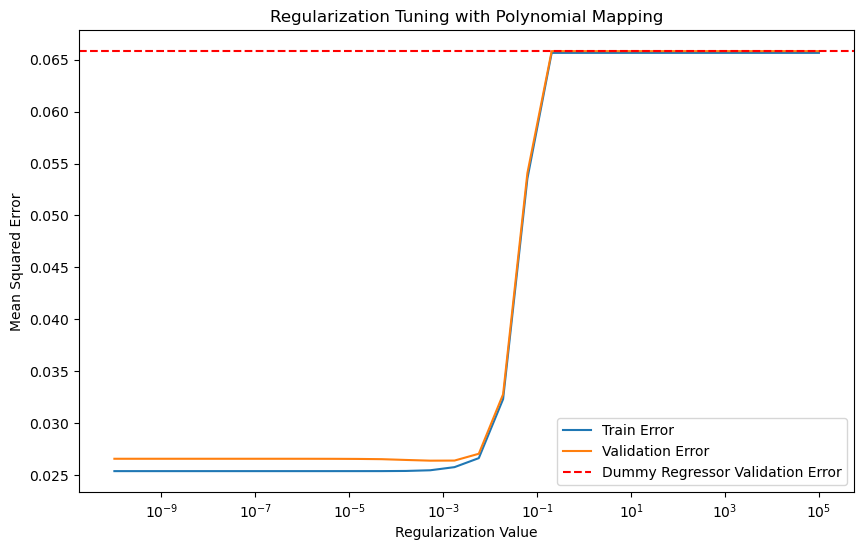

In [62]:
from sklearn.model_selection import GridSearchCV

# Q15: Tune the regularization strength of a Lasso regressor with the polynomial mapping 
# using cross validation (J = 5 as always).

# Define the parameter grid
param_grid = {'Lasso__alpha': np.logspace(-10, 5, 30)}

# Create the grid search object
grid_search = GridSearchCV(poly_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Fit the grid search to the data
grid_search.fit(subset_X_train, subset_y_train)

# Get the best hyperparameters
best_alpha = grid_search.best_params_['Lasso__alpha']
best_error = -grid_search.best_score_

# Plot the train and validation errors as a function of the hyperparameter
train_errors = -grid_search.cv_results_['mean_train_score']
val_errors = -grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(10, 6))
plt.semilogx(param_grid['Lasso__alpha'], train_errors, label='Train Error')
plt.semilogx(param_grid['Lasso__alpha'], val_errors, label='Validation Error')
plt.axhline(y=val_error_dummy, color='r', linestyle='--', label='Dummy Regressor Validation Error')
plt.xlabel('Regularization Value')
plt.ylabel('Mean Squared Error')
plt.title('Regularization Tuning with Polynomial Mapping')
plt.legend()


print("Best Regularization Value:", best_alpha)
print("Best Validation Error:", best_error)

In [63]:
# Task: Using the best performing hyperparameter, retrain the Lasso regressor on the entire 
# training set (= with all its samples).
subset_test_df_polyLasso = test_df_prepared[['PCR_04', 'PCR_06', 'contamination_level']]

subset_polyLasso_X_train = subset_X_train
subset_polyLasso_y_train = subset_y_train
subset_polyLasso_X_test = subset_test_df_polyLasso.drop(columns=['contamination_level']).to_numpy()
subset_polyLasso_y_test = subset_test_df_polyLasso['contamination_level'].to_numpy()

polyLassoRegressorForLater = Pipeline([('feature_mapping', PolynomialFeatures(degree=4, include_bias=False)),  
('normalization', MinMaxScaler(feature_range=(-1, 1))),  
('Lasso', Lasso(alpha=best_alpha, fit_intercept=True))])
polyLassoRegressorForLater.fit(subset_polyLasso_X_train, subset_polyLasso_y_train)



Pipeline(steps=[('feature_mapping',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('normalization', MinMaxScaler(feature_range=(-1, 1))),
                ('Lasso', Lasso(alpha=0.0005298316906283713))])

In [64]:
# find train error
cv_scores = cross_validate(polyLassoRegressorForLater, subset_polyLasso_X_train, subset_polyLasso_y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Calculate the mean train and validation errors
polyLasso_train_error = -cv_scores['train_score'].mean()
polyLasso_val_error = -cv_scores['test_score'].mean()


C:\Users\t-abarham\AppData\Local\Temp\ipykernel_24084\171725059.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


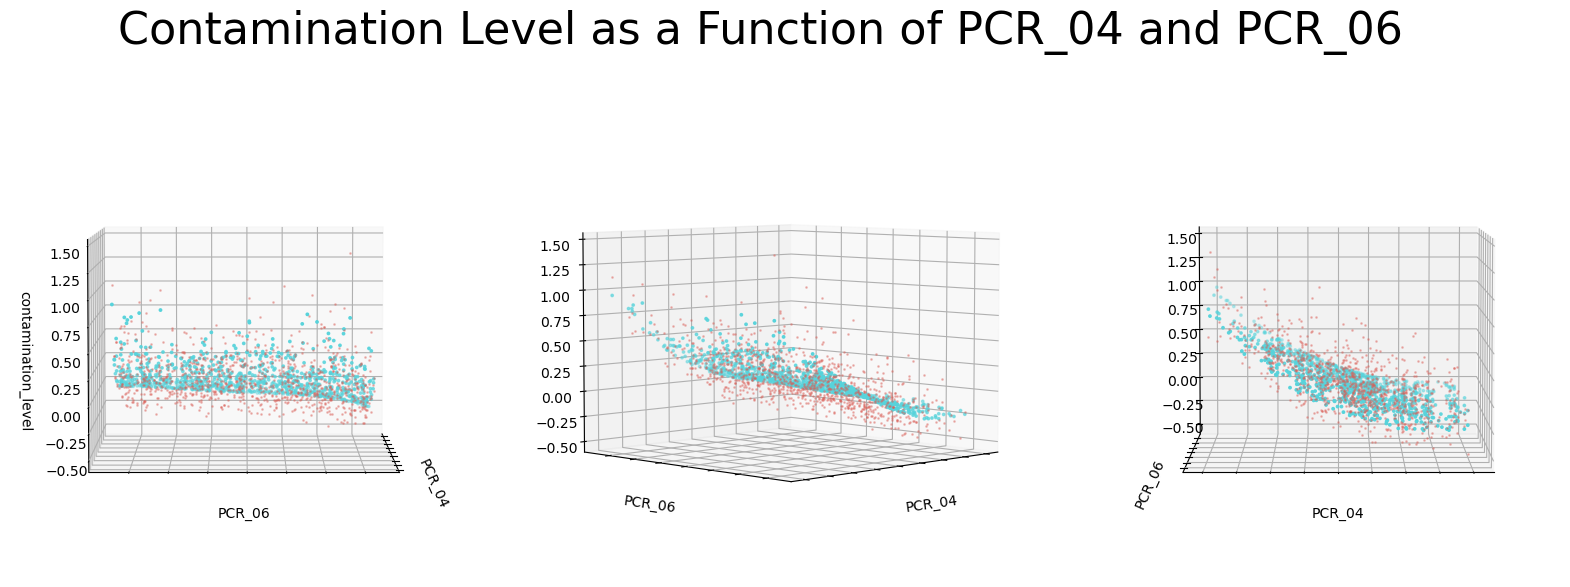

In [65]:
# Q16: We will now visualize the polynomial model you just trained. Use the new plot3d 
# function to plot all the training samples and their true labels (as before). Pass your 
# model predictions in a list to the predictions keyword to compare the true labels 
# to the predicted values. Attach the plot to your report. 
plot3d(subset_train_df, 'PCR_04', 'PCR_06', 'contamination_level', 'Contamination Level as a Function of PCR_04 and PCR_06', polyLassoRegressorForLater.predict(subset_polyLasso_X_train))

### Section 5: Fitting Gradient Boosted Machines (GBM) of the CovidScore 

In [66]:
# For this task, we will train a Scikit’s GBM regressor: GradientBoostingRegressor.  
# Apply the GBM regressor to the following features: PCR1, PCR2, PCR3, PCR4, 
# PCR5, PCR6, PCR9, PCR10, and sugar_levels.  
 
# Task: Create copies of your train and test sets (with all the relevant features).
train_df_prepared_section_5 = train_df_prepared.copy()
test_df_prepared_section_5 = test_df_prepared.copy()

# Create a subset of the training set with the relevant features and contamination_level.
subset_train_df_section_5 = train_df_prepared_section_5[['PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_09', 'PCR_10', 'sugar_levels', 'contamination_level']]
subset_X_train_section_5 = subset_train_df_section_5.drop(columns=['contamination_level']).to_numpy()
subset_y_train_section_5 = subset_train_df_section_5['contamination_level'].to_numpy()

# Create a subset of the test set with the relevant features and contamination_level.
subset_test_df_section_5 = test_df_prepared_section_5[['PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_09', 'PCR_10', 'sugar_levels', 'contamination_level']]
subset_X_test_section_5 = subset_test_df_section_5.drop(columns=['contamination_level']).to_numpy()
subset_y_test_section_5 = subset_test_df_section_5['contamination_level'].to_numpy()


Best Learning Rate: 0.1
Best Min Samples Leaf: 3
Best Validation Error: 0.0014492359551218676


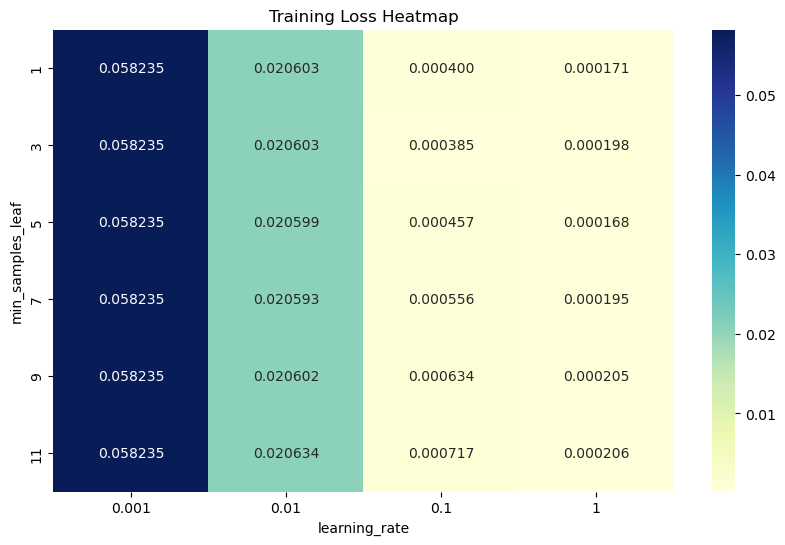

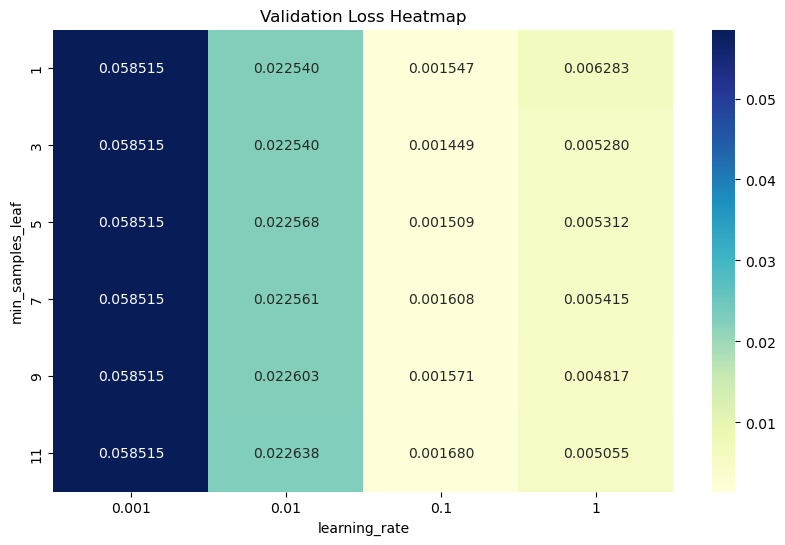

In [67]:
# Q18: Tune the ‘learning_rate’, and ‘min_samples_leaf’ parameters of the
# GradientBoostingRegressor model using cross-validation with a grid search (see Q8 in
# Major HW2). For the ‘loss’ parameter, use ‘huber’ (for further details regarding the Huber
# loss see here). Use a similar pipeline to the one created earlier in this section. Remember
# to attach required heatmaps, optimal hyper-parameters, and optimal train and validation
# errors (use the default values for all other parameters).

# Define the parameter grid
param_grid = {
    'learning_rate': [0.001 ,0.01, 0.1, 1],
    'min_samples_leaf': [1, 3, 5, 7, 9, 11]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=GradientBoostingRegressor(loss='huber'), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Fit the grid search to the data
grid_search.fit(subset_X_train_section_5, subset_y_train_section_5)

# Get the best hyperparameters
best_learning_rate = grid_search.best_params_['learning_rate']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_error = -grid_search.best_score_

# Print the best hyperparameters and error
print("Best Learning Rate:", best_learning_rate)
print("Best Min Samples Leaf:", best_min_samples_leaf)
print("Best Validation Error:", best_error)


# Get the grid search results
results = grid_search.cv_results_

# Extract the training and validation accuracies from the results
train_scores = -results['mean_train_score'].reshape(len(param_grid['learning_rate']), len(param_grid['min_samples_leaf']))
val_scores = -results['mean_test_score'].reshape(len(param_grid['learning_rate']), len(param_grid['min_samples_leaf']))

# Plot the heatmaps
plt.figure(figsize=(10, 6))
sns.heatmap(train_scores.T, annot=True, fmt=".6f", xticklabels=param_grid['learning_rate'], yticklabels=param_grid['min_samples_leaf'], cmap='YlGnBu')
plt.title("Training Loss Heatmap")
plt.xlabel("learning_rate")
plt.ylabel("min_samples_leaf")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(val_scores.T, annot=True, fmt=".6f", xticklabels=param_grid['learning_rate'], yticklabels=param_grid['min_samples_leaf'], cmap='YlGnBu')
plt.title("Validation Loss Heatmap")
plt.xlabel("learning_rate")
plt.ylabel("min_samples_leaf")
plt.show()

In [68]:
# Task: Train the GBM regressor on the entire training set and save it for future use
subset_gbm_X_train = subset_X_train_section_5
subset_gbm_y_train = subset_y_train_section_5
subset_gbm_X_test = subset_X_test_section_5
subset_gbm_y_test = subset_y_test_section_5


gbmRegressorForLater = GradientBoostingRegressor(learning_rate=best_learning_rate, min_samples_leaf=best_min_samples_leaf, loss='huber')
gbmRegressorForLater.fit(subset_gbm_X_train, subset_gbm_y_train) 

GradientBoostingRegressor(loss='huber', min_samples_leaf=3)

In [69]:
# find train error
cv_scores = cross_validate(gbmRegressorForLater
                           , subset_gbm_X_train, subset_gbm_y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Calculate the mean train and validation errors
gbm_train_error = -cv_scores['train_score'].mean()
gbm_val_error = -cv_scores['test_score'].mean()


### Section 6: Testing your models

In [71]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)
print("Train MSE for Dummy regressor: ", train_error_dummy)
print("Validation MSE for Dummy regressor: ", val_error_dummy)
print("Test MSE for Dummy regressor: ", mse(dummyRegressorForLater.predict(subset_dummy_X_test), subset_dummy_y_test))
print()

print("Train MSE for Linear regressor: ", linear_train_error)
print("Validation MSE for Linear regressor: ", linear_val_error)
print("Test MSE for Linear regressor: ", mse(best_regressor.predict(subset_linear_X_test), subset_linear_y_test))
print()

print("Train MSE for Lasso regressor: ", lasso_train_error)
print("Validation MSE for Lasso regressor: ", lasso_val_error)
print("Test MSE for Lasso regressor: ", mse(lassoRegressorForLater.predict(subset_lasso_X_test), subset_lasso_y_test))
print()

print("Train MSE for Polynomial Lasso regressor: ", polyLasso_train_error)
print("Validation MSE for Polynomial Lasso regressor: ", polyLasso_val_error)
print("Test MSE for Polynomial Lasso regressor: ", mse(polyLassoRegressorForLater.predict(subset_polyLasso_X_test), subset_polyLasso_y_test))
print()

print("Train MSE for GBM regressor: ", gbm_train_error)
print("Validation MSE for GBM regressor: ", gbm_val_error)
print("Test MSE for GBM regressor: ", mse(gbmRegressorForLater.predict(subset_gbm_X_test), subset_gbm_y_test))



Train MSE for Dummy regressor:  0.06565537988445821
Validation MSE for Dummy regressor:  0.06582366402220992
Test MSE for Dummy regressor:  0.07834638358893045

Train MSE for Linear regressor:  0.0072933761718224095
Validation MSE for Linear regressor:  0.007755798673287341
Test MSE for Linear regressor:  0.007902701431185778

Train MSE for Lasso regressor:  0.00730059874347785
Validation MSE for Lasso regressor:  0.007702296335533686
Test MSE for Lasso regressor:  0.007821757324217912

Train MSE for Polynomial Lasso regressor:  0.025459318265061898
Validation MSE for Polynomial Lasso regressor:  0.026385001415469678
Test MSE for Polynomial Lasso regressor:  0.023954345183478543

Train MSE for GBM regressor:  0.000382126717362724
Validation MSE for GBM regressor:  0.0015094991930828978
Test MSE for GBM regressor:  0.0010672358195997493
